In [ ]:
!pip install datasets

In [ ]:
import urllib.request
url = "https://raw.githubusercontent.com/YuhengHou/MLMA/main/Utils/EasyData.py"
urllib.request.urlretrieve(url, "EasyData.py")

('EasyData.py', <http.client.HTTPMessage at 0x78d9927e09d0>)

In [ ]:
import torch
import warnings
import importlib
import numpy as np
import pandas as pd
import urllib.request
import seaborn as sns
from EasyData import EasyData
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load Embedding
embed = torch.load("/content/drive/MyDrive/models/esm2_delta_embeddings.pt") # embed = torch.load("/content/drive/MyDrive/models/esm2_embeddings.pt")
X, y = embed['X'], embed['y']

if not isinstance(X, np.ndarray): #to np arr
    X = X.cpu().numpy()
    y = y.cpu().numpy()

In [ ]:
pipline = EasyData(embedding=X)
final_dataset = pipline.prepare_data()

In [ ]:
def report_score(model, dataset, to_numeric=False, model_name=None, feature_set=None, feature_dict=None):
    """
    Train the given model on the dataset, evaluate accuracy, and optionally record feature importances.

    Parameters:
    - model: a scikit-learn–style estimator with fit/predict methods.
    - dataset: pandas DataFrame containing features and a "Mapped Cancer Stage" target column.
    - to_numeric: (unused) placeholder for future numeric conversion logic.
    - model_name: identifier string for storing feature importances.
    - feature_set: name of the feature set (key under model_name in feature_dict).
    - feature_dict: dict to collect feature importance Series by model_name and feature_set.

    Returns:
    - acc: test set accuracy.
    """
    # Copy input to avoid modifying the original DataFrame
    input_df = dataset.copy()

    # Encode all object‐dtype columns as categorical integers
    for col in input_df.select_dtypes(include='object').columns:
        input_df[col] = pd.factorize(input_df[col])[0].astype("category")

    # Ensure the target is integer type
    input_df["Mapped Cancer Stage"] = input_df["Mapped Cancer Stage"].astype(int)
    print(input_df["Mapped Cancer Stage"].value_counts())  # show class distribution

    # Split data into train/val/test with stratification
    df_split = pipline.stratified_splitting(full_dataset=input_df, random_state=42)

    # Prepare training data
    X_train = df_split["train"].drop(columns=["Mapped Cancer Stage"])
    y_train = df_split["train"]["Mapped Cancer Stage"]

    # Fit the model
    model.fit(X_train, y_train)

    # Prepare validation data (not used here except to show pattern)
    X_val = df_split["val"].drop(columns=["Mapped Cancer Stage"])
    y_val = df_split["val"]["Mapped Cancer Stage"]
    _ = model.predict(X_val)  # you could evaluate val performance if needed

    # Prepare test data and make predictions
    X_test = df_split["test"].drop(columns=["Mapped Cancer Stage"])
    y_test = df_split["test"]["Mapped Cancer Stage"]
    y_pred = model.predict(X_test)

    # Compute accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"ACC of test: {acc:.4f}")

    # Print detailed classification metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # If feature importances are available, store them
    if feature_dict is not None and hasattr(model, 'feature_importances_'):
        if model_name not in feature_dict:
            feature_dict[model_name] = {}

        feature_dict[model_name][feature_set] = pd.Series(
            model.feature_importances_, index=X_train.columns
        )

    return acc

In [ ]:
def plot_model_comparison(results):
    """
    Plot a side-by-side bar chart comparing LightGBM and XGBoost accuracies.

    Parameters:
    - results: dict
        A dictionary where each key is a label (e.g., feature set name)
        and each value is another dict with keys 'LightGBM' and 'XGBoost'
        mapping to their accuracy scores.
    """
    # Extract labels and scores
    labels = list(results.keys())
    lightgbm_scores = [results[key]['LightGBM'] for key in labels]
    xgboost_scores = [results[key]['XGBoost'] for key in labels]

    # Set up bar positions
    x = np.arange(len(labels))
    width = 0.35  # width of each bar

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 5))
    # Bars for LightGBM
    rects1 = ax.bar(
        x - width/2,
        lightgbm_scores,
        width,
        label='LightGBM',
        color='#FFB347'  # soft orange
    )
    # Bars for XGBoost
    rects2 = ax.bar(
        x + width/2,
        xgboost_scores,
        width,
        label='XGBoost',
        color='#FFD700'  # gold
    )

    # Add labels and title
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Accuracy Comparison on Different Input Sets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1.05)  # show full range from 0 to just above 1
    ax.legend(loc='lower right')

    # Annotate each bar with its height
    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(
            f'{height:.2f}',
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),           # offset text by 3 points above bar
            textcoords="offset points",
            ha='center',            # horizontal alignment
            va='bottom'             # vertical alignment
        )

    # Add a light grid on y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()  # adjust layout to fit everything
    plt.show()

In [ ]:
LGB_model = LGBMClassifier(verbose=-1, num_class = 4)
XGB_model = XGBClassifier(objective='multi:softprob', num_class=4,eval_metric='mlogloss',use_label_encoder=False,random_state=42)

In [ ]:
feature_dict = {}
results = {'a1': {}, 'a2': {}, 'a3': {}}

# a1
print("Performance of a1 - LightGBM")
acc = report_score(model=LGB_model, dataset=final_dataset["a1"], to_numeric=False, model_name="LightGBM", feature_set='a1', feature_dict=feature_dict)
results['a1']['LightGBM'] = acc

print("Performance of a1 - XGBoost")
acc = report_score(model = XGB_model, dataset = final_dataset["a1"], to_numeric = False, model_name="XGBoost", feature_set='a1', feature_dict=feature_dict)
results['a1']['XGBoost'] = acc

# a2
print("Performance of a2 - LightGBM")
acc = report_score(model=LGB_model, dataset=final_dataset["a2"], to_numeric=True, model_name="LightGBM", feature_set='a2', feature_dict=feature_dict)
results['a2']['LightGBM'] = acc

print("Performance of a2 - XGBoost")
acc = report_score(model=XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='mlogloss', use_label_encoder=False, random_state=42, enable_categorical=True), dataset=final_dataset["a2"], to_numeric=True, model_name="XGBoost", feature_set='a2', feature_dict=feature_dict)
results['a2']['XGBoost'] = acc

# a3
print("Performance of a3 - LightGBM")
acc = report_score(model=LGB_model, dataset=final_dataset["a3"], to_numeric=True, model_name="LightGBM", feature_set='a3', feature_dict=feature_dict)
results['a3']['LightGBM'] = acc

print("Performance of a3 - XGBoost")
acc = report_score(model=XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='mlogloss', use_label_encoder=False, random_state=42, enable_categorical=True), dataset=final_dataset["a3"], to_numeric=True, model_name="XGBoost", feature_set='a3', feature_dict=feature_dict)
results['a3']['XGBoost'] = acc

Performance of a1 - LightGBM
Mapped Cancer Stage
1    25572
0     7182
3     3208
2     2296
Name: count, dtype: int64
ACC of test: 0.7462

Classification Report:
              precision    recall  f1-score   support

           0     0.9429    0.2296    0.3693      1437
           1     0.7267    0.9977    0.8409      5115
           2     0.9817    0.2326    0.3761       460
           3     0.9885    0.2675    0.4211       643

    accuracy                         0.7462      7655
   macro avg     0.9099    0.4319    0.5018      7655
weighted avg     0.8046    0.7462    0.6892      7655

Performance of a1 - XGBoost
Mapped Cancer Stage
1    25572
0     7182
3     3208
2     2296
Name: count, dtype: int64
ACC of test: 0.8077

Classification Report:
              precision    recall  f1-score   support

           0     0.9288    0.4447    0.6014      1437
           1     0.7817    0.9926    0.8746      5115
           2     0.9886    0.3783    0.5472       460
           3     0.9899

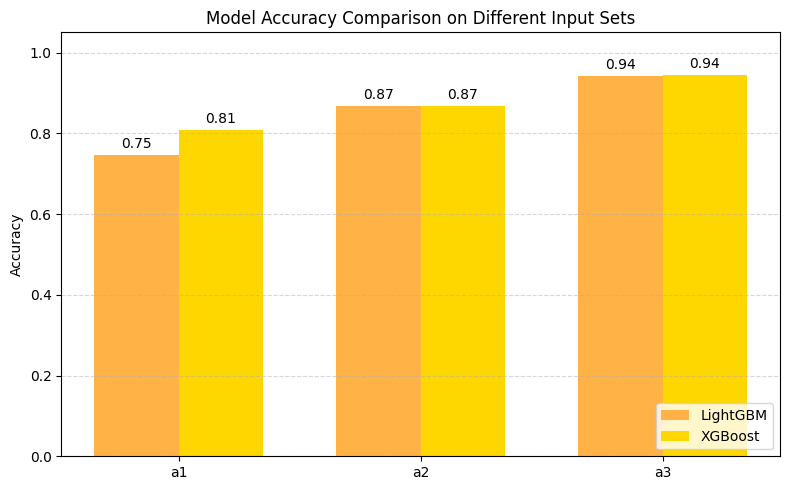

In [ ]:
plot_model_comparison(results)

In [ ]:
#Feature importance
def plot_top_features(feature_dict, top_n=10):
    for model_name, model_data in feature_dict.items():
        for feature_set, series in model_data.items():
            top_features = series.sort_values(ascending=False).head(top_n)
            plt.figure(figsize=(8, 5))
            top_features[::-1].plot(kind='barh')
            plt.title(f"{model_name} Top {top_n} Features - {feature_set}")
            plt.xlabel("Importance")
            plt.tight_layout()
            plt.show()

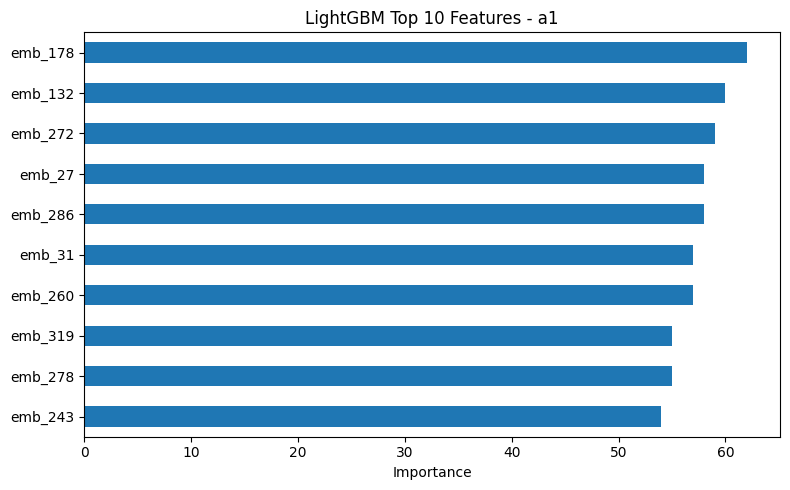

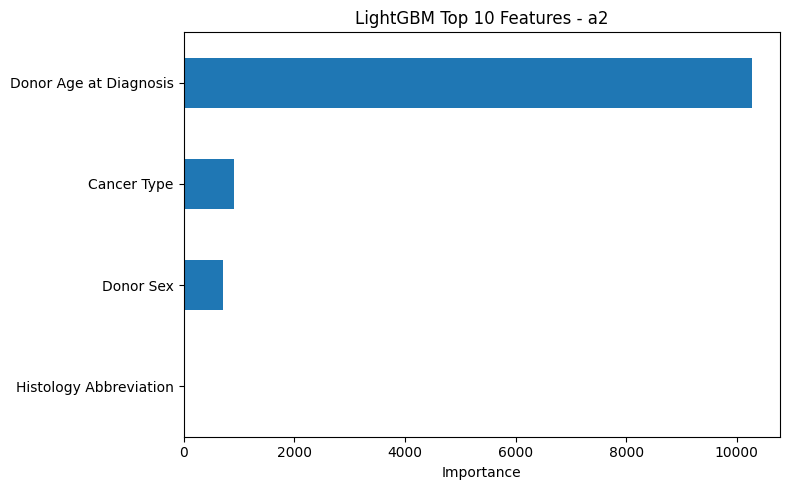

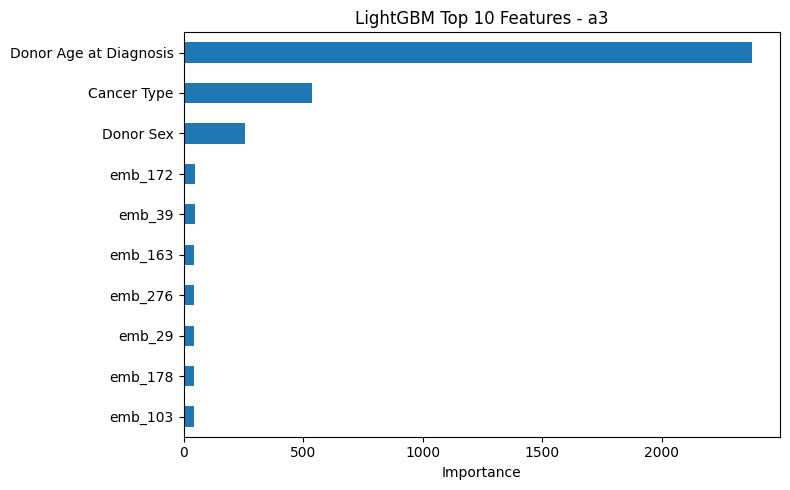

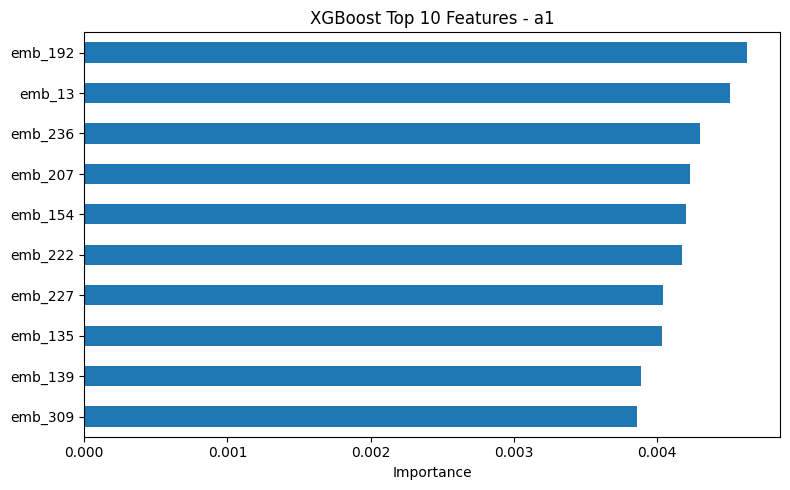

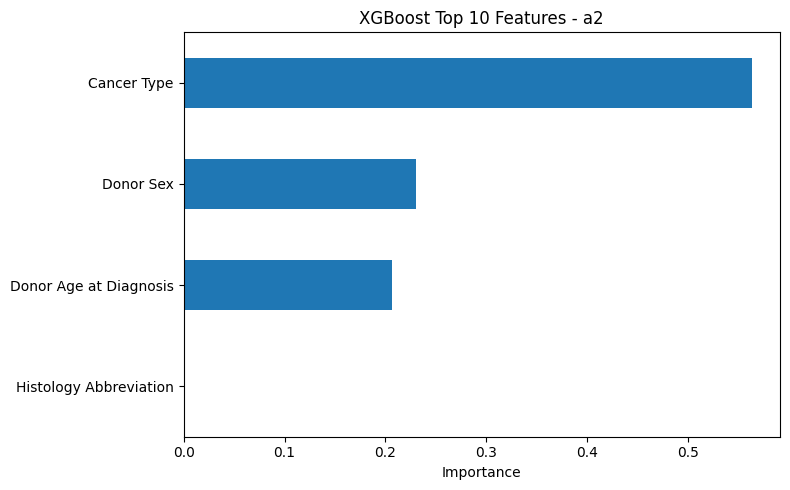

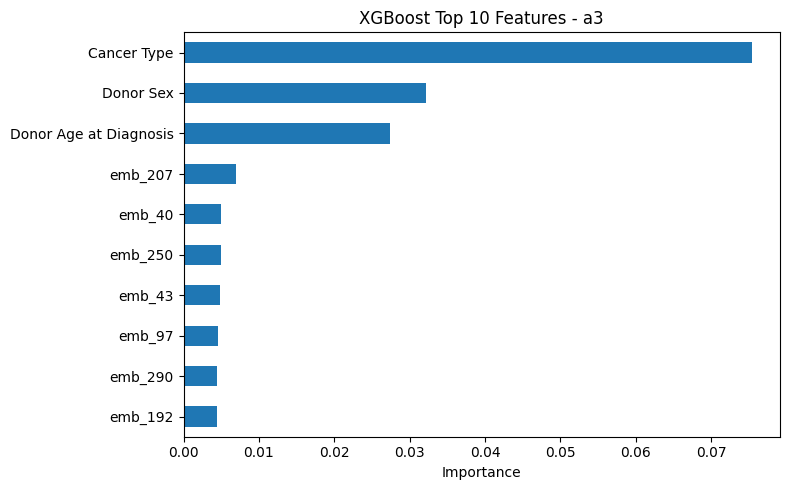

In [ ]:
plot_top_features(feature_dict, top_n=10)